In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/Group Project/Cross.zip' -d '/content/drive/My Drive/Group Project/Cross'

## Functions

In [ ]:
import os
import h5py
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import json
import os
from tensorflow.keras import regularizers
import h5py
import numpy as np
import re
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling2D, Flatten, Dense, ReLU, BatchNormalization, Reshape, Softmax, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import gc
from tensorflow.keras import backend as K
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import sys

In [ ]:
TRAIN_DATA_PATH = '/content/drive/My Drive/Group Project/Cross/train'
TEST1_DATA_PATH = '/content/drive/My Drive/Group Project/Cross/test1'
TEST2_DATA_PATH = '/content/drive/My Drive/Group Project/Cross/test2'
TEST3_DATA_PATH = '/content/drive/My Drive/Group Project/Cross/test3'

In [ ]:
# Function to read MEG data from h5 files
def read_meg_data(file_path, filename):
    with h5py.File(file_path, 'r') as file:
        temp = filename.split('_')[:-1]
        dataset_name = "_".join(temp)
        meg_data = file.get(dataset_name)[()]
        return meg_data


# Function to preprocess data
def preprocess_data(data):
    # Randomly select 248*3 columns from the 35624 columns
    selected_columns = np.random.choice(data.shape[1], size=data.shape[0]*3, replace=False)
    processed_data = data[:, selected_columns]
    return processed_data

# Function to load data and labels from a directory
def load_data_from_directory(directory):
    data = []
    labels = []

    for file_name in os.listdir(directory):
        if file_name.endswith('.h5'):
            file_path = os.path.join(directory, file_name)
            meg_data = read_meg_data(file_path, file_name)
            processed_data = preprocess_data(meg_data)
            data.append(processed_data)

            # Assuming your file names are like "class1_capture1.h5", extract class label
            splitted_file_name = file_name.split('_')
            if splitted_file_name[0] == 'rest':
                labels.append('rest')
            elif splitted_file_name[0] == 'task':
                if splitted_file_name[1] == 'motor':
                    labels.append('motor')
                elif splitted_file_name[1] == 'story':
                    labels.append('story')
                elif splitted_file_name[1] == 'working':
                    labels.append('memory')

    return np.array(data), np.array(labels)

In [ ]:
def create_model(params):
    model = models.Sequential([
    layers.Conv2D(128, kernel_size=params['kernel_size1'], activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(params['dropout_rate1']),
    layers.BatchNormalization(),
    layers.Conv2D(512, kernel_size=params['kernel_size1'], activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(params['dropout_rate1']),
    layers.Conv2D(256, kernel_size=params['kernel_size2'], activation='relu'),
    layers.MaxPooling2D(2, 3),
    layers.Conv2D(128, kernel_size=params['kernel_size2'], activation='relu'),
    layers.MaxPooling2D(2, 3),
    layers.Dropout(params['dropout_rate1']),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learn_rate'])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
def create_model_simple(params):
    model = models.Sequential([
        layers.Conv2D(4, kernel_size=params['kernel_size1'], activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
        layers.MaxPooling2D(5, 5),
        layers.BatchNormalization(),
        layers.Conv2D(8, kernel_size=params['kernel_size2'], activation='relu'),
        layers.MaxPooling2D(4, 4),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(params['l2_lambda'])),
        layers.Dropout(params['dropout_rate1']),
        layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(params['l2_lambda'])),
        layers.Dropout(params['dropout_rate1']),
        layers.Dense((4), activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learn_rate'])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
# Define EarlyStopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

In [ ]:
checkpoint_path = "best_model.h5"
model_checkpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=25)

## Data load and processing


In [ ]:
X_train, y_train = load_data_from_directory(TRAIN_DATA_PATH)

In [ ]:
X_test1, y_test1 = load_data_from_directory(TEST1_DATA_PATH)
X_test2, y_test2 = load_data_from_directory(TEST2_DATA_PATH)
X_test3, y_test3 = load_data_from_directory(TEST3_DATA_PATH)

In [ ]:
X_train.shape, y_train.shape, X_test1.shape, y_test1.shape, X_test2.shape, y_test2.shape, X_test3.shape, y_test3.shape

((64, 248, 744),
 (64,),
 (16, 248, 744),
 (16,),
 (16, 248, 744),
 (16,),
 (16, 248, 744),
 (16,))

In [ ]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=32)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test1 = label_encoder.fit_transform(y_test1)
y_test2 = label_encoder.fit_transform(y_test2)
y_test3 = label_encoder.fit_transform(y_test3)
y_val = label_encoder.fit_transform(y_val)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test1.shape, y_test1.shape, X_test2.shape, y_test2.shape, X_test3.shape, y_test3.shape

((48, 248, 744),
 (48,),
 (16, 248, 744),
 (16,),
 (16, 248, 744),
 (16,),
 (16, 248, 744),
 (16,),
 (16, 248, 744),
 (16,))

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test1 = scaler.fit_transform(X_test1.reshape(X_test1.shape[0], -1)).reshape(X_test1.shape)
X_test2 = scaler.fit_transform(X_test2.reshape(X_test2.shape[0], -1)).reshape(X_test2.shape)
X_test3 = scaler.fit_transform(X_test3.reshape(X_test3.shape[0], -1)).reshape(X_test3.shape)
X_val = scaler.fit_transform(X_val.reshape(X_val.shape[0], -1)).reshape(X_val.shape)

In [ ]:
# Compile the model
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
K.clear_session()
gc.collect()

0

## Export session

In [ ]:
import pickle

In [ ]:
objects_to_save = {
    'X_train': X_train,
    'X_test1': X_test1,
    'X_test2': X_test2,
    'X_test3': X_test3,
    'X_val': X_val,
    'y_train': y_train,
    'y_test1': y_test1,
    'y_test2': y_test2,
    'y_test3': y_test3,
    'y_val': y_val
}

In [ ]:
with open('/content/drive/My Drive/Group Project/saved_objects_cross.pkl', 'wb') as f:
    pickle.dump(objects_to_save, f)

## Imoport session

In [ ]:
with open('/content/drive/My Drive/Group Project/saved_objects_cross.pkl', 'rb') as f:
    globals().update(pickle.load(f))

## Grid Search

In [ ]:
# Define the range of values for each hyperparameter
param_grid = {
    'kernel_size1': [(9, 27), (5, 15)],
    'kernel_size2': [(9, 27),(5, 15)],
    'dropout_rate1': [0.35, 0.5],
    'learn_rate': [0.0001, 0.001],
    'l2_lambda': [0.01, 0.001]
}

# Generate all combinations of hyperparameters
grid = ParameterGrid(param_grid)

results = []
best_accuracy = 0.0
best_params = None
size_best_model = 0
best_history = None


for params in grid:
    print("Parameters of the iteration: ", params)

    # Build and compile the model with the current set of hyperparameters
    model = create_simple_model(params)

    checkpoint_path = checkpoint_path = '/content/drive/My Drive/Group Project/Models_Simple_Cross/best_model_grid.h5'
    model_checkpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=30)

    # Train the model
    history = model.fit(X_train, y_train, batch_size=12, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

    # Evaluate the model on the validation set
    val_accuracy = max(history.history['val_accuracy'])  # Get the best validation accuracy

    # Update the best model if the current model is better
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params
        size_best_model = model.count_params()  # Get the number of parameters in the model
        best_history = history
        # Optionally, save the model
        model.save('/content/drive/My Drive/Group Project/Models_Simple_Cross/best_model_grid_overall_v2.h5')


    # Update the results dictionary
    results.append({
        'kernel_size1': params['kernel_size1'],
        'kernel_size2': params['kernel_size2'],
        'dropout_rate1': params['dropout_rate1'],
        'learn_rate': params['learn_rate'],
        'val_accuracy': val_accuracy
    })


    # Clear session, delete model, and collect garbage
    K.clear_session()
    del model
    del history
    del val_accuracy
    gc.collect()


# Print the best model's information
print("Best model's accuracy:", best_accuracy)
print("Best model's parameters:", best_params)
print("Size of the best model (number of parameters):", size_best_model)

# At the end you shoul end up with the model that has acheived the best accuracy on the test set (formed by the 3 test set in cross folder merged)
# and also the best scaling for the model -- the model is saved in best_model_path-

import matplotlib.pyplot as plt

# Function to plot training history
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(best_history)

In [ ]:
import pandas as pd

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Optionally, save the DataFrame to a CSV file
results_df.to_csv('/content/drive/My Drive/Group Project/Models_Simple_Cross/grid_search_results.csv', index=False)

In [ ]:
results_df

,kernel_size1,kernel_size2,dropout_rate1,learn_rate,l2_lambda,val_accuracy
0,"(9, 27)","(9, 27)",0.35,0.0001,0.001,0.7500
1,"(9, 27)","(9, 27)",0.35,0.0010,0.001,0.5000
2,"(9, 27)","(9, 27)",0.35,0.0001,0.010,0.2500
3,"(9, 27)","(9, 27)",0.35,0.0010,0.010,0.8125
4,"(9, 27)","(5, 15)",0.35,0.0001,0.001,0.6250
5,"(9, 27)","(5, 15)",0.35,0.0010,0.001,0.5000
6,"(9, 27)","(5, 15)",0.35,0.0001,0.010,0.2500
7,"(9, 27)","(5, 15)",0.35,0.0010,0.010,0.2500
8,"(5, 15)","(9, 27)",0.35,0.0001,0.001,0.3125
9,"(5, 15)","(9, 27)",0.35,0.0010,0.001,0.4375


## Model Test


In [ ]:
from tensorflow.keras.models import load_model


### Best Model Small:
# Best model's parameters: {'dropout_rate1': 0.35, 'kernel_size1': (15, 63), 'kernel_size2': (15, 63), 'l2_lambda': 0.01, 'learn_rate': 0.0001}
# Size of the best model (number of parameters): 52668

# Load the best model
modelss = '/content/drive/My Drive/Group Project/Models_Cross/'
best_model = load_model(modelss + "best_model_grid_overall.h5")

In [ ]:
for layer in best_model.layers:
    config = layer.get_config()  # Get the configuration of the layer
    print(f"Layer Name: {layer.name}")
    print("Layer Configuration:")
    for key, value in config.items():
        print(f"  {key}: {value}")
    print("\n")

In [ ]:
# Evaluate the model
val_loss, val_acc = best_model.evaluate(X_val, y_val)
print(f'Val accuracy, loss: {val_acc, val_loss}')
test_loss, test_acc = best_model.evaluate(X_test1, y_test1)
print(f'Test1 accuracy: {test_acc}')
test_loss, test_acc = best_model.evaluate(X_test2, y_test2)
print(f'Test2 accuracy: {test_acc}')
test_loss, test_acc = best_model.evaluate(X_test3, y_test3)
print(f'Test3 accuracy: {test_acc}')

1/1 [==============================] - 2s 2s/step - loss: 1.5690 - accuracy: 1.0000
Val accuracy, loss: (1.0, 1.5689805746078491)
1/1 [==============================] - 0s 46ms/step - loss: 1.7460 - accuracy: 0.5000
Test1 accuracy: 0.5
1/1 [==============================] - 0s 45ms/step - loss: 1.7358 - accuracy: 0.2500
Test2 accuracy: 0.25
1/1 [==============================] - 0s 49ms/step - loss: 1.7230 - accuracy: 0.3125
Test3 accuracy: 0.3125


1/1 [==============================] - 0s 24ms/step


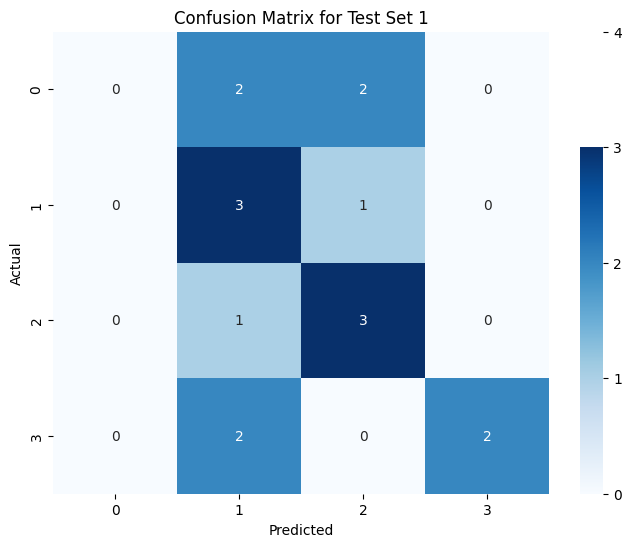

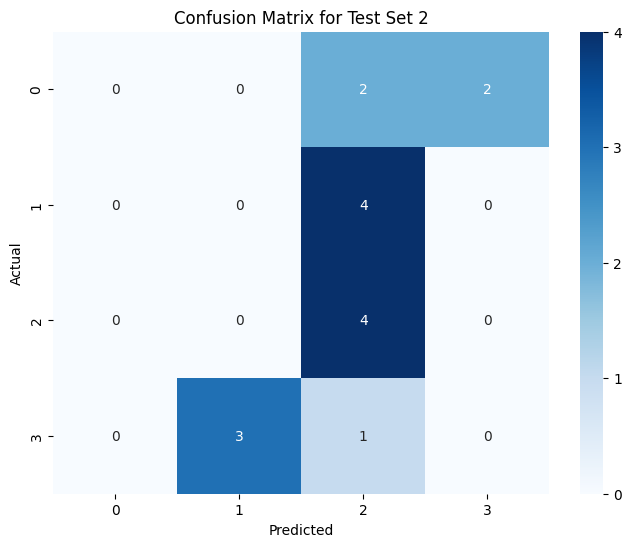

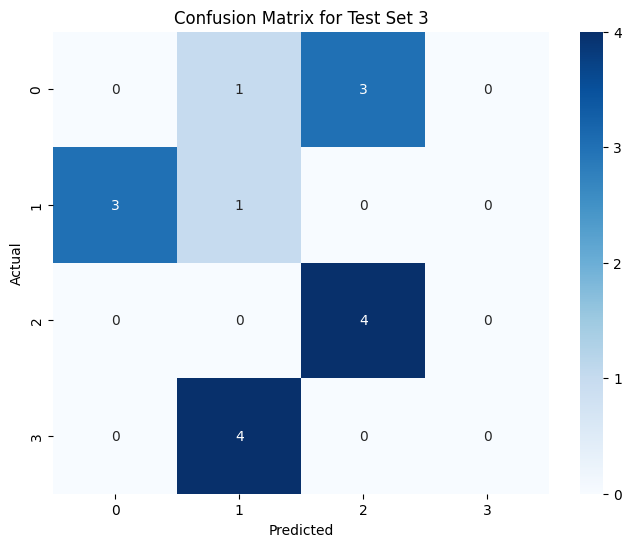

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions
y_pred1 = best_model.predict(X_test1)
y_pred1 = np.argmax(y_pred1, axis=1)
y_pred2 = best_model.predict(X_test2)
y_pred2 = np.argmax(y_pred2, axis=1)
y_pred3 = best_model.predict(X_test3)
y_pred3 = np.argmax(y_pred3, axis=1)

# Compute confusion matrices
cm1 = confusion_matrix(y_test1, y_pred1)
cm2 = confusion_matrix(y_test2, y_pred2)
cm3 = confusion_matrix(y_test3, y_pred3)

def plot_confusion_matrix(cm, title, name_file):
    plt.figure(figsize=(6, 6))  # Increase the figure size as needed
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 12})  # Increase 'annot_kws' size as needed
    plt.title(title, fontsize=16)  # Increase title font size as needed
    plt.ylabel('Actual', fontsize=14)  # Increase ylabel font size as needed
    plt.xlabel('Predicted', fontsize=14)  # Increase xlabel font size as needed

    # Modify the colorbar
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 1, 2, 3, 4])
    colorbar.set_ticklabels(['0', '1', '2', '3', '4']

    save_path = '/content/drive/My Drive/Group Project/Models_Simple_Cross/' + name_file
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()


# Plotting each confusion matrix
plot_confusion_matrix(cm1, 'Confusion Matrix for Test Set 1', "cross_cm_1.png")
plot_confusion_matrix(cm2, 'Confusion Matrix for Test Set 2', "cross_cm_2.png")
plot_confusion_matrix(cm3, 'Confusion Matrix for Test Set 3', "cross_cm_3.png")